In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from scipy.linalg import sqrtm
import ternary

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_multinomial' in c['name'] 
                    and c['config']['experiment']['batch_size'] == 8]

In [3]:
def w2_multinom_pairwise(ps):
    # build pop cov matrix
    def pop_cov(x):
        n = len(x)
        c = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                c[i, j] = x[i]*(1 - x[i]) if i == j else -x[i]*x[j]
        return c

    ps = np.array(ps)
    n = len(ps)
    dists = np.zeros((n, n))

    sigs = [pop_cov(p) for p in ps]
    roots = [sqrtm(s) for s in sigs]

    for i in range(n):
        for j in range(n):
            mu_diff = np.sum((ps[i] - ps[j])**2)
            mid = sqrtm(roots[i] @ sigs[j] @ roots[i])
            if np.iscomplexobj(mid):
                mid = mid.real
            cov_diff = np.trace(sigs[i] + sigs[j] - 2*mid)
            dists[i, j] = np.sqrt(mu_diff + cov_diff)

    return dists

In [4]:
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [5]:
classy = TinyCNN()
classy.load_state_dict(torch.load('notebooks/mnist_classifier/mnist_tinycnn.pth'))
classy.to('cuda')

TinyCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [6]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

points_per_dim = 3
k = 3

set_size = 100

mix_probs_labels = simplex_grid(k, points_per_dim)

# fr_dist = multinomial_fr(mix_probs)

n_sets = len(mix_probs_labels)

mix_probs = torch.tensor(np.repeat(mix_probs_labels, n_sets//k, axis=1))

dataset = MNISTDataset(n_classes=k, n_sets=n_sets, set_size=5000)
mixer = SetMixer(k=k, mixed_set_size=set_size, n_mixed_sets=n_sets)
mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)
mixed_sets = mixed_sets.to(torch.float).to('cuda')


In [7]:
# d = {
#     "Encoder" : [],
#     "Generation class error" : []
# }

# with torch.no_grad():

#     for c in cfg:


#         encoder, generator = load_model(c['config'], c['dir'], 'cuda')
        
#         rec = generator.sample(encoder(mixed_sets.reshape(n_sets, set_size, 1, 28, 28)), num_samples=100)

#         preds = classy(rec.reshape(set_size*n_sets, 1, 28, 28)).argmax(dim=1).reshape(n_sets, set_size)

#         compositions = torch.stack([(set_preds.bincount(minlength=10)) for set_preds in preds])

#         est = compositions[:, :3].cpu().numpy()/100


#         error = est - mix_probs_labels


#         d['Encoder'].append(c['encoder'])
#         d['Generation class error'].append((error**2).mean())
# print(pd.DataFrame(d))

In [8]:
def batched_dists(mixed_sets, mix_probs, encoder, batch_size=8, device='cuda'):

    with torch.no_grad():
        
        zs = []
        for i in range(0, mixed_sets.size(0), batch_size):
            x_chunk = mixed_sets[i:i+batch_size].to(device)
            z_chunk = encoder(x_chunk).cpu()  # offload!
            zs.append(z_chunk)
        z = torch.cat(zs, dim=0).to(device)  # full z back on gpu :)

    return w2_multinom_pairwise(mix_probs), torch.cdist(z, z, p=2)

In [9]:
def plot_ternary(ax, dists, mix_probs, title=None, scale=99):

    prob_tuples = [tuple(map(int, np.round(s * scale))) for s in mix_probs]
    anchor_idx = prob_tuples.index((scale//3, scale//3, scale//3))
    # anchor_idx = 0
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h")
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

    tax.scatter([prob_tuples[anchor_idx]], marker='*', color='pink', s=100, zorder=10)

/tmp/ipykernel_685015/2002123837.py:25: RuntimeWarning: invalid value encountered in sqrt
  dists[i, j] = np.sqrt(mu_diff + cov_diff)
/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


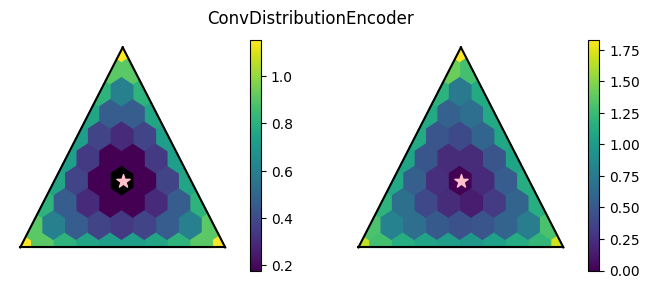

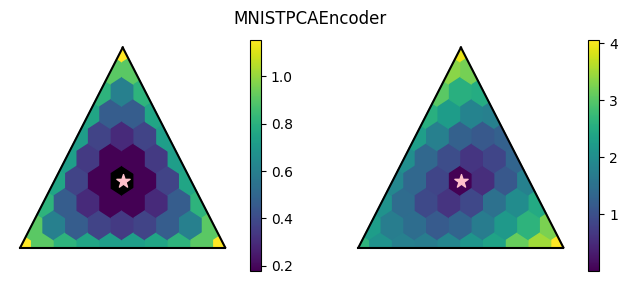

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


/tmp/ipykernel_685015/2002123837.py:25: RuntimeWarning: invalid value encountered in sqrt
  dists[i, j] = np.sqrt(mu_diff + cov_diff)
/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


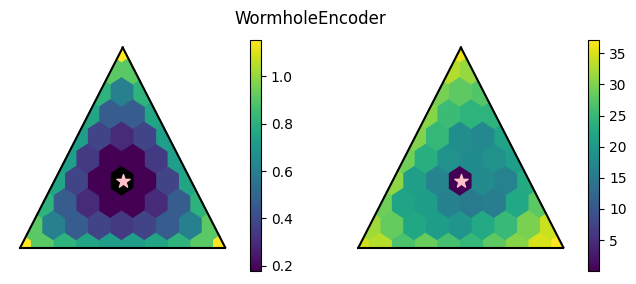

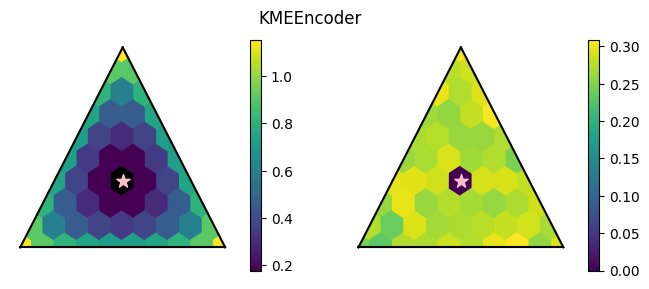

                   encoder      corr
0  ConvDistributionEncoder  0.977646
1          MNISTPCAEncoder  0.866095
2          WormholeEncoder  0.894347
3               KMEEncoder  0.187647


In [10]:
corrs = []  # we'll store correlations here :)

for idx in range(len(cfg)):
    
    name = cfg[idx]['encoder']
    k = 3
    points_per_dim = 10
    set_size = 1000

    # build simplex grid :)
    mix_probs_labels = simplex_grid(k, points_per_dim)
    n_sets = len(mix_probs_labels)
    mix_probs = torch.tensor(np.repeat(mix_probs_labels, n_sets // k, axis=1))

    dataset = MNISTDataset(n_classes=k, n_sets=n_sets, set_size=5000)
    mixer = SetMixer(k=k, mixed_set_size=set_size, n_mixed_sets=n_sets)
    mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)
    mixed_sets = mixed_sets.to(torch.float).to('cuda')

    encoder, _ = load_model(cfg[idx]['config'], cfg[idx]['dir'], 'cuda')

    # get distance !
    w, l = batched_dists(mixed_sets.reshape(n_sets, set_size, 1, 28, 28), mix_probs_labels, encoder)

    # plot it  :)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    fig.suptitle(name)
    plot_ternary(axs[0], w, mix_probs_labels, scale=9)
    plot_ternary(axs[1], l.cpu(), mix_probs_labels, scale=9)
    plt.show()

    np.save('numerical_results/mnist_multinomial_%s_dists.npy'%name, l.cpu().numpy())

    # correlate!
    w_flat, l_flat = torch.tensor(w.flatten()), l.flatten().cpu()
    mask = ~torch.isnan(w_flat) & ~torch.isnan(l_flat)
    if mask.sum() > 1:
        corr = torch.corrcoef(torch.stack([w_flat[mask], l_flat[mask]]))[0, 1].item()
    else:
        corr = float('nan')  # if too few points, set as nan
    corrs.append({'encoder': name, 'corr': corr})

corr_table = pd.DataFrame(corrs)
print(corr_table)


In [11]:
corr_table.to_csv('numerical_results/multinomial_mnist_correlations.csv')